# Librairies

In [1]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from pytictoc import TicToc

from numpy.random import seed
seed(1)



/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rootDir = '/home/charles/Projects/NeuralNetPopulation'
provider = 'Mapbox'
gridSize = 100
resp="v_CA16_406"
finalNonLin = 'linear'
optimizerClass = Adam
lrInit=10**-2

In [3]:
sys.path.append("/home/charles/Projects/NeuralNetPopulation/Python") #watch out, PosixPath do not work

from dataGeneration.dataGeneratorFactory import DataGeneratorFactory
from dataGeneration.rawDataInput import RawDataInput

from models.convNetParams import ConvNetParams
from models.mdlFit import MdlFit
from utils.pathBuilder import PathBuilder

checkpointPath = Path("/home/charles//Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100")

In [4]:
#Limit the number of images read in memory
ubNumTotal = 50

# Load the model, and dataloader objects

In [5]:
myPathBuilder = PathBuilder(rootDir,
                                provider,
                                gridSize)

myRawDataInput = RawDataInput(myPathBuilder,
                                  idGrid='gridId',
                                  provider=provider,
                                  gridSize=gridSize,
                                  resp=resp,
                                  ubNumTotal=ubNumTotal)  # consider a small subset


Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/PredictionError/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Partition/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FinalModel/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/ModelHistory/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Log/mdlFittingLogs/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FeatureMaps/Mapbox/100 already exists


In [6]:
os.path.isdir(checkpointPath)

True

# Get a bunch of models

In [8]:
dictModels={}
dictModels["mdl_SGDEluLinear"] = load_model(checkpointPath /"Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.005_batchSize_32_numEpochs_30_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_linear_penultimateNonLin_elu_checkpoint_loss.h5")
dictModels["mdl_AdamReluLinear"] = load_model(checkpointPath / "Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_30_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_AdamfinalNonLinearity_linear_penultimateNonLin_relu_checkpoint_loss.h5")
dictModels["mdl_SGDReluRelu"] = load_model(checkpointPath / "Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_150_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_relu_penultimateNonLin_relu_checkpoint_loss.h5")
dictModels["mdl_SGDTanhRelu"] = load_model( myPathBuilder.modelsOutputPath / 'model_Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_30_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_linear_penultimateNonLin_tanh.h5')
dictModels["mdl_SGDEluTanh"] = load_model(checkpointPath /  'Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.005_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_tanh_penultimateNonLin_elu_mean_absolute_error_checkpoint_loss.h5')

In [9]:
numModels=len(dictModels.keys())

# Get the weights in the last fc layer

In [11]:
listDfX=[]
listDfb=[]

for k in dictModels.keys():
    X,b = dictModels[k].get_layer('fc2').get_weights()
    dfX=pd.DataFrame(X.ravel(), columns=['weight'])
    dfX['id'] = k
    listDfX.append(dfX)
    
    dfB=pd.DataFrame(b.ravel(), columns=['weight'])
    dfB['id'] = k
    listDfb.append(dfB)
 

In [12]:
dfAllX=pd.concat(listDfX) 
dfAllX.head()

weight                id
0 -0.003912  mdl_SGDEluLinear
1  0.005171  mdl_SGDEluLinear
2  0.005332  mdl_SGDEluLinear
3 -0.051043  mdl_SGDEluLinear
4 -0.057124  mdl_SGDEluLinear

In [13]:
dfAllb=pd.concat(listDfb) 
dfAllb.head()

weight                id
0 -0.004981  mdl_SGDEluLinear
1 -0.003688  mdl_SGDEluLinear
2 -0.005024  mdl_SGDEluLinear
3 -0.143136  mdl_SGDEluLinear
4 -0.146804  mdl_SGDEluLinear

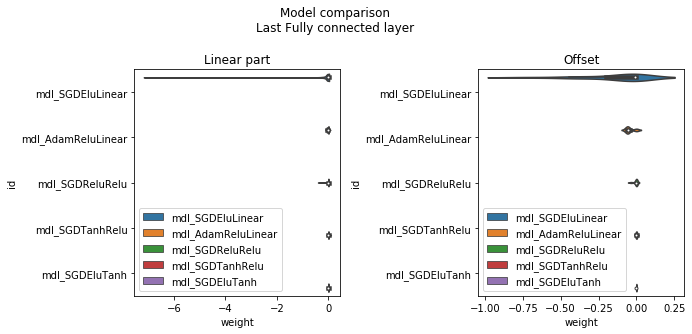

In [14]:
f=plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.violinplot(x="weight" , y='id', hue='id', data=dfAllX)
plt.title('Linear part')
plt.legend(loc='lower left')

plt.subplot(1,2,2)
sns.violinplot(x="weight" , y='id',  hue='id', data=dfAllb)
plt.title('Offset')
plt.legend(loc='best')

plt.suptitle('Model comparison\nLast Fully connected layer', y=0.95)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.85])

f.savefig( myPathBuilder.figuresOutputPath / 'ModelCompare' / f'weightFCCompare{numModels}Models.png')

21867617